In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install upsetplot

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for upsetplot: filename=upsetplot-0.9.0-py3-none-any.whl size=24866 sha256=be3fe62b482ee96758195cf906f4d3378af410b5c592fbee887ad13c6fce7b2c
  Stored in directory: /root/.cache/pip/wheels/7b/ce/88/1d0bce5b2680165c29c3e68416325e79674d5a9f422d037996
Successfully built upsetplot


In [4]:
import pandas as pd
import gzip
from upsetplot import UpSet, from_memberships, from_contents, from_indicators
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.special import rel_entr
from itertools import chain, combinations
from collections import defaultdict, Counter
import random
import pickle

In [5]:
# Define the base folder path to your project directory in Google Drive
Ds_project_folder_path = '/content/drive/MyDrive/DS_project/'

# Folder where raw input data is stored
raw_data_path = 'Data/1_raw_data/'

# Folder where processed output data will be saved
gene_name_mapping_data_path = 'Data/2_gene_name_mapping_data/'

clinical_data_path = 'Data/0.clinical_rdata_to_csv/'

filtered_by_plate_rna_seq_data_path = 'Data/3_RNA_seq_sample_filtering_by_plate/'

data_clearning_path = 'Data/4_Intra-cohort-preprocessing/4.1.Data_clearning/'

In [6]:
# Whether to use gene-mapped data (True) or raw probe-based data (False)

gene_mapping = False

#### Data Import

In [7]:
def RNA_seq_and_CNV_data_load(gene_mapping = True):
  RNA_seq_path = Ds_project_folder_path + filtered_by_plate_rna_seq_data_path

  if gene_mapping:
    CNV_path = Ds_project_folder_path + gene_name_mapping_data_path
    GBM_rna_seq_data = pd.read_csv(RNA_seq_path + 'TCGA-GBM_mRNA_gene_map_filtered_by_plate.csv', index_col=0)
    LGG_rna_seq_data = pd.read_csv(RNA_seq_path + 'TCGA-LGG_mRNA_gene_map_filtered_by_plate.csv', index_col=0)

    GBM_CNV_data = pd.read_csv(CNV_path + 'TCGA-GBM_CNV_gene_mapping.csv', index_col=0)
    LGG_CNV_data = pd.read_csv(CNV_path + 'TCGA-LGG_CNV_gene_mapping.csv', index_col=0)

  else:
    CNV_path = Ds_project_folder_path + raw_data_path

    GBM_rna_seq_data = pd.read_csv(RNA_seq_path + 'TCGA-GBM_mRNA_filtered_chromosome.csv', index_col=0)
    LGG_rna_seq_data = pd.read_csv(RNA_seq_path + 'TCGA-LGG_mRNA_filtered_chromosome.csv', index_col=0)

    GBM_CNV_data = pd.read_csv(RNA_seq_path + 'TCGA-GBM_CNV_filtered_chromosome.csv', index_col=0)
    LGG_CNV_data = pd.read_csv(RNA_seq_path + 'TCGA-LGG_CNV_filtered_chromosome.csv', index_col=0)

  return GBM_rna_seq_data, LGG_rna_seq_data, GBM_CNV_data, LGG_CNV_data

In [8]:
with gzip.open(Ds_project_folder_path + raw_data_path + 'TCGA_GBM_SNV.tsv.gz', 'rt') as f:
    GBM_SNV_data = pd.read_csv(f, sep='\t')
with gzip.open(Ds_project_folder_path + raw_data_path + 'TCGA_LGG_SNV.tsv.gz', 'rt') as f:
    LGG_SNV_data = pd.read_csv(f, sep='\t')

with gzip.open(Ds_project_folder_path + raw_data_path + 'TCGA-GBM.protein.tsv.gz', 'rt') as f:
    GBM_protein_data = pd.read_csv(f, sep='\t')
with gzip.open(Ds_project_folder_path + raw_data_path + 'TCGA-LGG.protein.tsv.gz', 'rt') as f:
    LGG_protein_data = pd.read_csv(f, sep='\t')

with gzip.open(Ds_project_folder_path + raw_data_path + 'TCGA_GBM_mval_methylation.tsv.gz', 'rt') as f:
    GBM_methlylation_data = pd.read_csv(f, sep='\t')
with gzip.open(Ds_project_folder_path + raw_data_path + 'TCGA_LGG_mval_methylation.tsv.gz', 'rt') as f:
    LGG_methlylation_data = pd.read_csv(f, sep='\t')

In [9]:
GBM_rna_seq_data, LGG_rna_seq_data, GBM_CNV_data, LGG_CNV_data = RNA_seq_and_CNV_data_load(gene_mapping)

In [10]:
GBM_patient_info = pd.read_csv(Ds_project_folder_path + clinical_data_path + 'TCGA-GBM_clinicalXML_patient.csv', index_col=0)
LGG_patient_info = pd.read_csv(Ds_project_folder_path + clinical_data_path + 'TCGA-LGG_clinicalXML_patient.csv', index_col=0)

In [11]:
GBM_SNV_sample = list(set(GBM_SNV_data.columns[1:].to_list()))
LGG_SNV_sample = list(set(LGG_SNV_data.columns[1:].to_list()))

GBM_protein_sample = list(set(GBM_protein_data.columns[1:].to_list()))
LGG_protein_sample = list(set(LGG_protein_data.columns[1:].to_list()))

GBM_methylation_sample = list(set(GBM_methlylation_data.columns.to_list()))
LGG_methylation_sample = list(set(LGG_methlylation_data.columns.to_list()))

GBM_CNV_sample = list(set(GBM_CNV_data.columns[1:].to_list()))
LGG_CNV_sample = list(set(LGG_CNV_data.columns[1:].to_list()))

GBM_rna_seq_sample = list(set(GBM_rna_seq_data.columns.to_list()))
LGG_rna_seq_sample = list(set(LGG_rna_seq_data.columns.to_list()))

GBM_patient_info_sample = list(set(GBM_patient_info.index.to_list()))
LGG_patient_info_sample = list(set(LGG_patient_info.index.to_list()))

total_GBM_sample = list(set(GBM_CNV_sample + GBM_SNV_sample + GBM_protein_sample + GBM_methylation_sample + GBM_rna_seq_sample))
total_LGG_sample = list(set(LGG_CNV_sample + LGG_SNV_sample + LGG_protein_sample + LGG_methylation_sample + LGG_rna_seq_sample))

#### frunction for data visualization

In [12]:
def assign_samples_by_omics_priority(omics_dict):
    """
    Assign samples to unique omics combinations in order of descending omics coverage.

    Parameters:
        omics_dict (dict): A dictionary where keys are omics layer names
                           and values are sets of sample IDs that have that omics data.

    Returns:
        pd.DataFrame: A table of omics combinations, the number of uniquely assigned samples,
                      and the corresponding sample IDs.
    """
    # Build mapping: sample ID → set of omics layers it belongs to
    sample_to_omics = defaultdict(set)
    for omics, samples in omics_dict.items():
        for sample in samples:
            sample_to_omics[sample].add(omics)

    # Build mapping: omics combination → set of sample IDs
    combination_to_samples = defaultdict(set)
    for sample, omics_set in sample_to_omics.items():
        combo = '+'.join(sorted(omics_set))  # use sorted order for consistency
        combination_to_samples[combo].add(sample)

    # Sort combinations by number of omics layers (descending)
    sorted_combos = sorted(
        combination_to_samples.items(),
        key=lambda x: -len(x[0].split('+'))  # prioritize more complex omics combinations
    )

    # Assign samples to the highest-priority combination they belong to
    assigned_samples = set()
    results = []

    for combo, samples in sorted_combos:
        unique = samples - assigned_samples  # remove already assigned samples
        if unique:
            results.append({
                'Omics Combination': combo,
                'Num Samples': len(unique),
                'Sample IDs': sorted(unique)
            })
            assigned_samples.update(unique)

    # Return results as a sorted DataFrame
    return pd.DataFrame(results).sort_values(by='Num Samples', ascending=False)


def plot_upset_from_omics_combinations(omics_combination_df, title="UpSet Plot"):
    """
    Generate an UpSet plot from a DataFrame of omics combinations and sample IDs.

    Parameters:
        omics_combination_df (pd.DataFrame): Output from assign_samples_by_omics_priority().
            Must contain columns 'Omics Combination' and 'Sample IDs'.
        title (str): Plot title.
    """
    # 1. Flatten sample-to-omics mapping
    sample_to_omics = []
    for _, row in omics_combination_df.iterrows():
        omics_list = row['Omics Combination'].split('+')
        for sample in row['Sample IDs']:
            sample_to_omics.append((sample, omics_list))

    # 2. Construct binary DataFrame (samples x omics)
    all_omics = sorted({o for _, omics in sample_to_omics for o in omics})
    all_samples = sorted({s for s, _ in sample_to_omics})
    df_binary = pd.DataFrame(0, index=all_samples, columns=all_omics)

    for sample, omics in sample_to_omics:
        df_binary.loc[sample, omics] = 1

    df_binary = df_binary.astype(bool)

    # 3. Create UpSet input Series
    df_upset = from_indicators(df_binary.columns, df_binary)

    # 4. Plot
    plt.figure(figsize=(10, 10))
    UpSet(
        df_upset,
        subset_size='count',
        show_counts=True,
        sort_by='cardinality',
        sort_categories_by='cardinality'
    ).plot()
    plt.suptitle(title)
    plt.show()

In [13]:
GBM_omics = {
    'CNV': set(GBM_CNV_sample),
    'SNV': set(GBM_SNV_sample),
    'Protein': set(GBM_protein_sample),
    'Methylation': set(GBM_methylation_sample),
    'RNAseq': set(GBM_rna_seq_sample)
}

LGG_omics = {
    'CNV': set(LGG_CNV_sample),
    'SNV': set(LGG_SNV_sample),
    'Protein': set(LGG_protein_sample),
    'Methylation': set(LGG_methylation_sample),
    'RNAseq': set(LGG_rna_seq_sample)
}

GBM_omics_and_clinical = {
    'CNV': set([sample[:-4] for sample in GBM_CNV_sample]),
    'SNV': set([sample[:-4] for sample in GBM_SNV_sample]),
    'Protein': set([sample[:-4] for sample in GBM_protein_sample]),
    'Methylation': set([sample[:-4] for sample in GBM_methylation_sample]),
    'RNAseq': set([sample[:-4] for sample in GBM_rna_seq_sample]),
    'clinical data': set(GBM_patient_info_sample)
}

LGG_omics_and_clinical = {
    'CNV': set([sample[:-4] for sample in LGG_CNV_sample]),
    'SNV': set([sample[:-4] for sample in LGG_SNV_sample]),
    'Protein': set([sample[:-4] for sample in LGG_protein_sample]),
    'Methylation': set([sample[:-4] for sample in LGG_methylation_sample]),
    'RNAseq': set([sample[:-4] for sample in LGG_rna_seq_sample]),
    'clinical data': set(LGG_patient_info_sample)
}


In [14]:
GBM_omics_combinations = assign_samples_by_omics_priority(GBM_omics_and_clinical)
LGG_omics_combinations = assign_samples_by_omics_priority(LGG_omics_and_clinical)

/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

<Figure size 1000x1000 with 0 Axes>

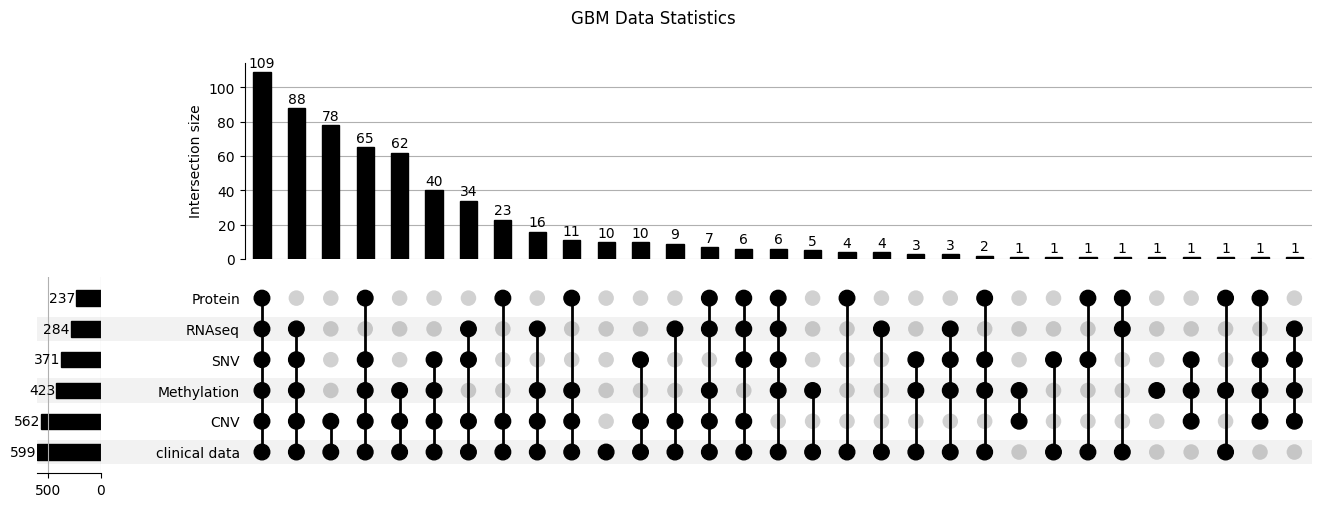

/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

<Figure size 1000x1000 with 0 Axes>

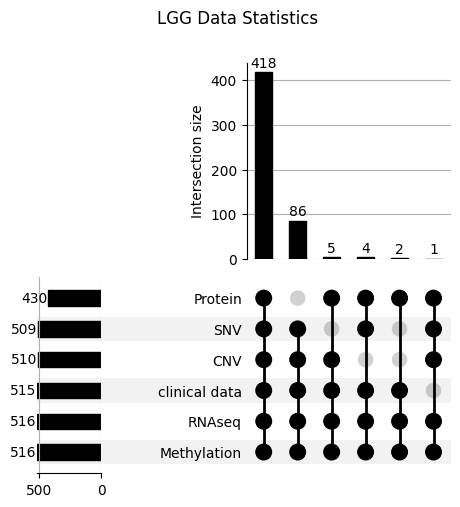

In [15]:
plot_upset_from_omics_combinations(GBM_omics_combinations, title="GBM Data Statistics")
plot_upset_from_omics_combinations(LGG_omics_combinations, title="LGG Data Statistics")

Sample filtering by clinical data

- to align sample with clinical data

In [16]:
filtered_GBM_sample_list_by_clinical_data = list(set(GBM_patient_info_sample) & set(total_GBM_sample))
filtered_LGG_sample_list_by_clinical_data = list(set(LGG_patient_info_sample) & set(total_LGG_sample))

In [17]:
def sort_samples(sample_list):
    def sort_key(sample_id):
        parts = sample_id.split('-')
        sample_type = parts[-1]  # '01A', '02A', '01B'
        num_part = int(sample_type[:2])   # '01' → 1
        letter = sample_type[-1]          # 'A', 'B'

        alpha_priority = 0 if letter == 'A' else 1
        return (alpha_priority, num_part)

    return sorted(sample_list, key=sort_key)

In [18]:
print("# of GBM patients in clinical data: ", len(GBM_patient_info_sample))
print("# of LGG patients in clinical data: ", len(LGG_patient_info_sample))

print("# of GBM samples in omics layers: ", len(total_GBM_sample))
print("# of LGG samples in omics layers: ", len(total_LGG_sample))

filtered_GBM_sample = [sample for sample in total_GBM_sample if sample[:-4] in GBM_patient_info_sample]
filtered_LGG_sample = [sample for sample in total_LGG_sample if sample[:-4] in LGG_patient_info_sample]

GBM_patient_samples_template = {sample[:-4]: [] for sample in filtered_GBM_sample}
LGG_patient_samples_template = {sample[:-4]: [] for sample in filtered_LGG_sample}

for sample in filtered_GBM_sample:
  GBM_patient_samples_template[sample[:-4]].append(sample)

for sample in filtered_LGG_sample:
  LGG_patient_samples_template[sample[:-4]].append(sample)

filtered_GBM_sample_list_by_clinical_data = []
filtered_LGG_sample_list_by_clinical_data = []

for k, v in GBM_patient_samples_template.items():
  filtered_GBM_sample_list_by_clinical_data.append(sort_samples(v)[0])

for k, v in LGG_patient_samples_template.items():
  filtered_LGG_sample_list_by_clinical_data.append(sort_samples(v)[0])

print("# of filtered GBM sample : ",len(filtered_GBM_sample_list_by_clinical_data))
print("# of filtered LGG sample : ", len(filtered_LGG_sample_list_by_clinical_data))

# of GBM patients in clinical data:  599
# of LGG patients in clinical data:  515
# of GBM samples in omics layers:  613
# of LGG samples in omics layers:  534
# of filtered GBM sample :  589
# of filtered LGG sample :  515


In [19]:
GBM_SNV_align_clinical_sample = [sample for sample in GBM_SNV_sample if sample in filtered_GBM_sample_list_by_clinical_data]
LGG_SNV_align_clinical_sample = [sample for sample in LGG_SNV_sample if sample in filtered_LGG_sample_list_by_clinical_data]

GBM_protein_align_clinical_sample = [sample for sample in GBM_protein_sample if sample in filtered_GBM_sample_list_by_clinical_data]
LGG_protein_align_clinical_sample = [sample for sample in LGG_protein_sample if sample in filtered_LGG_sample_list_by_clinical_data]

GBM_methylation_align_clinical_sample = [sample for sample in GBM_methylation_sample if sample in filtered_GBM_sample_list_by_clinical_data]
LGG_methylation_align_clinical_sample = [sample for sample in LGG_methylation_sample if sample in filtered_LGG_sample_list_by_clinical_data]

GBM_CNV_align_clinical_sample = [sample for sample in GBM_CNV_sample if sample in filtered_GBM_sample_list_by_clinical_data]
LGG_CNV_align_clinical_sample = [sample for sample in LGG_CNV_sample if sample in filtered_LGG_sample_list_by_clinical_data]

GBM_rna_seq_align_clinical_sample = [sample for sample in GBM_rna_seq_sample if sample in filtered_GBM_sample_list_by_clinical_data]
LGG_rna_seq_align_clinical_sample = [sample for sample in LGG_rna_seq_sample if sample in filtered_LGG_sample_list_by_clinical_data]

In [39]:
GBM_omics_align_clinical = {
    'CNV': set([i[:-4] for i in GBM_SNV_align_clinical_sample]),
    'SNV': set([i[:-4] for i in GBM_CNV_align_clinical_sample]),
    'Protein': set([i[:-4] for i in GBM_protein_align_clinical_sample]),
    'Methylation': set([i[:-4] for i in GBM_methylation_align_clinical_sample]),
    'RNAseq': set([i[:-4] for i in GBM_rna_seq_align_clinical_sample]),
    'clinical data': set(i[:-4] for i in GBM_SNV_align_clinical_sample+GBM_CNV_align_clinical_sample+
                         GBM_protein_align_clinical_sample+GBM_methylation_align_clinical_sample+GBM_rna_seq_align_clinical_sample if i[:-4] in GBM_patient_info_sample)
}

LGG_omics_align_clinical  = {
    'CNV': set([i[:-4] for i in LGG_SNV_align_clinical_sample]),
    'SNV': set([i[:-4] for i in LGG_CNV_align_clinical_sample]),
    'Protein': set([i[:-4] for i in LGG_protein_align_clinical_sample]),
    'Methylation': set([i[:-4] for i in LGG_methylation_align_clinical_sample]),
    'RNAseq': set([i[:-4] for i in LGG_rna_seq_align_clinical_sample]),
    'clinical data': set(LGG_patient_info_sample)
}

/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

<Figure size 1000x1000 with 0 Axes>

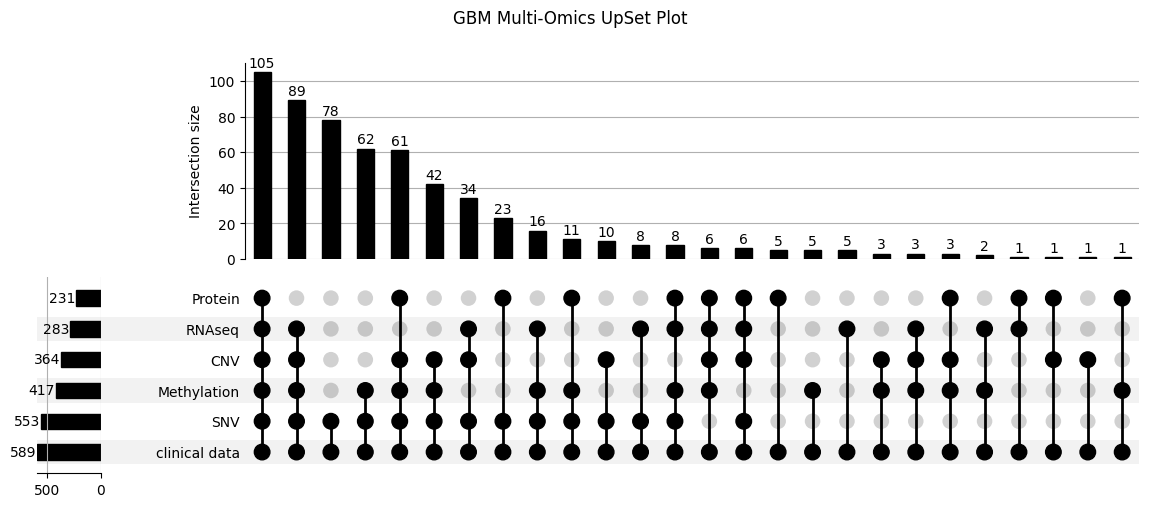

/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

<Figure size 1000x1000 with 0 Axes>

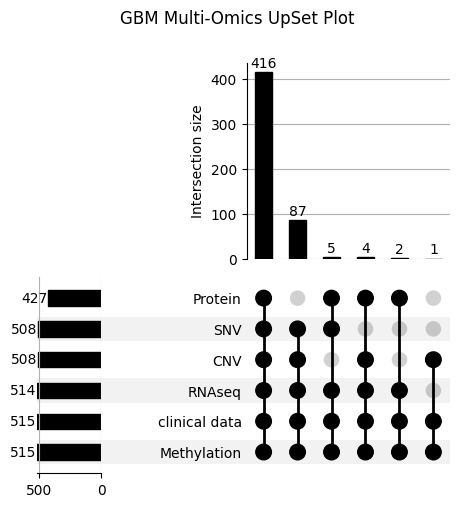

In [40]:
GBM_omics_combinations = assign_samples_by_omics_priority(GBM_omics_align_clinical)
LGG_omics_combinations = assign_samples_by_omics_priority(LGG_omics_align_clinical)
plot_upset_from_omics_combinations(GBM_omics_combinations, title="GBM Multi-Omics UpSet Plot")
plot_upset_from_omics_combinations(LGG_omics_combinations, title="GBM Multi-Omics UpSet Plot")

#### Sample filtering by NA value

#### for MOFA

MOFA allows modality missing values for each sample. MOFA is robust to missing data and supports approximately 50% missing samples for each modality.
Therefore, we use the following two MOFA-customized filtering methods.

1. Since the model's performance varies depending on the modalities available for each sample, we set a modality_number threshold to filter out samples with insufficient modality coverage.  
2. Even if the modality is sufficient, if the data within the modality is insufficient, performance will not be achieved, so we remove samples where more than 50% of the data is NA.  



In [36]:
# parameter
modality_number = 2

In [37]:
GBM_sample_modality_number = {sample:0 for sample in filtered_GBM_sample_list_by_clinical_data}
LGG_sample_modality_number = {sample:0 for sample in filtered_LGG_sample_list_by_clinical_data}

for sample in filtered_GBM_sample_list_by_clinical_data:
  if sample in GBM_SNV_align_clinical_sample:
    GBM_sample_modality_number[sample] += 1
  if sample in GBM_protein_align_clinical_sample:
    GBM_sample_modality_number[sample] += 1
  if sample in GBM_methylation_align_clinical_sample:
    GBM_sample_modality_number[sample] += 1
  if sample in GBM_CNV_align_clinical_sample:
    GBM_sample_modality_number[sample] += 1
  if sample in GBM_rna_seq_align_clinical_sample:
    GBM_sample_modality_number[sample] += 1

for sample in filtered_LGG_sample_list_by_clinical_data:
  if sample in LGG_CNV_align_clinical_sample:
    LGG_sample_modality_number[sample] += 1
  if sample in LGG_protein_align_clinical_sample:
    LGG_sample_modality_number[sample] += 1
  if sample in LGG_methylation_align_clinical_sample:
    LGG_sample_modality_number[sample] += 1
  if sample in LGG_SNV_align_clinical_sample:
    LGG_sample_modality_number[sample] += 1
  if sample in LGG_rna_seq_align_clinical_sample:
    LGG_sample_modality_number[sample] += 1

In [38]:
GBM_SNV_MOFA_sample = [sample for sample in GBM_SNV_align_clinical_sample if GBM_sample_modality_number[sample] >= modality_number]
LGG_SNV_MOFA_sample = [sample for sample in LGG_SNV_align_clinical_sample if LGG_sample_modality_number[sample] >= modality_number]

GBM_protein_MOFA_sample = [sample for sample in GBM_protein_align_clinical_sample if GBM_sample_modality_number[sample] >= modality_number]
LGG_protein_MOFA_sample = [sample for sample in LGG_protein_align_clinical_sample if LGG_sample_modality_number[sample] >= modality_number]

GBM_methylation_MOFA_sample = [sample for sample in GBM_methylation_align_clinical_sample if GBM_sample_modality_number[sample] >= modality_number]
LGG_methylation_MOFA_sample = [sample for sample in LGG_methylation_align_clinical_sample if LGG_sample_modality_number[sample] >= modality_number]

GBM_CNV_MOFA_sample = [sample for sample in GBM_CNV_align_clinical_sample if GBM_sample_modality_number[sample] >= modality_number]
LGG_CNV_MOFA_sample = [sample for sample in LGG_CNV_align_clinical_sample if LGG_sample_modality_number[sample] >= modality_number]

GBM_rna_seq_MOFA_sample = [sample for sample in GBM_rna_seq_align_clinical_sample if GBM_sample_modality_number[sample] >= modality_number]
LGG_rna_seq_MOFA_sample = [sample for sample in LGG_rna_seq_align_clinical_sample if LGG_sample_modality_number[sample] >= modality_number]

In [55]:
def check_NA_ratio(samples, check_gbm = True):
  result = []
  if check_gbm:
    for sample in samples:
      na_count = 0
      total_count = 0
      if sample in GBM_SNV_data.columns:
        na_count += GBM_SNV_data[sample].isna().sum()
        total_count += len(GBM_SNV_data[sample])
      if sample in GBM_protein_data.columns:
        na_count += GBM_protein_data[sample].isna().sum()
        total_count += len(GBM_protein_data[sample])
      if sample in GBM_methlylation_data.columns:
        na_count += GBM_methlylation_data[sample].isna().sum()
        total_count += len(GBM_methlylation_data[sample])
      if sample in GBM_CNV_data.columns:
        na_count += GBM_CNV_data[sample].isna().sum()
        total_count += len(GBM_CNV_data[sample])
      if sample in GBM_rna_seq_data.columns:
        na_count += GBM_rna_seq_data[sample].isna().sum()
        total_count += len(GBM_rna_seq_data[sample])
      if (na_count/total_count) > 0.5:
        result.append(1)
      else:
        result.append(0)

  else:
    for sample in samples:
      na_count = 0
      total_count = 0
      if sample in LGG_SNV_data.columns:
        na_count += LGG_SNV_data[sample].isna().sum()
        total_count += len(LGG_SNV_data[sample])
      if sample in LGG_protein_data.columns:
        na_count += LGG_protein_data[sample].isna().sum()
        total_count += len(LGG_protein_data[sample])
      if sample in LGG_methlylation_data.columns:
        na_count += LGG_methlylation_data[sample].isna().sum()
        total_count += len(LGG_methlylation_data[sample])
      if sample in LGG_CNV_data.columns:
        na_count += LGG_CNV_data[sample].isna().sum()
        total_count += len(LGG_CNV_data[sample])
      if sample in LGG_rna_seq_data.columns:
        na_count += LGG_rna_seq_data[sample].isna().sum()
        total_count += len(LGG_rna_seq_data[sample])
      if (na_count/total_count) > 0.5:
        result.append(1)
      else:
        result.append(0)

  return result

In [50]:
filtered_GBM_smaples = set(GBM_SNV_MOFA_sample + GBM_protein_MOFA_sample + GBM_methylation_MOFA_sample + GBM_CNV_MOFA_sample+ GBM_rna_seq_MOFA_sample)
filtered_LGG_samples = set(LGG_SNV_MOFA_sample+ LGG_protein_MOFA_sample + LGG_methylation_MOFA_sample + LGG_CNV_MOFA_sample + LGG_rna_seq_MOFA_sample)

In [56]:
print('# of GBM samples after NA filtered: ', sum(check_NA_ratio(filtered_GBM_smaples, check_gbm = True)))
print('# of LGG samples after NA filtered: ', sum(check_NA_ratio(filtered_LGG_samples, check_gbm = False)))

# of GBM samples after NA filtered:  0
# of LGG samples after NA filtered:  0


In [60]:
GBM_omics_MOFA = {
    'CNV': set([i[:-4] for i in GBM_CNV_MOFA_sample]),
    'SNV': set([i[:-4] for i in GBM_SNV_MOFA_sample]),
    'Protein': set([i[:-4] for i in GBM_protein_MOFA_sample]),
    'Methylation': set([i[:-4] for i in GBM_methylation_MOFA_sample]),
    'RNAseq': set([i[:-4] for i in GBM_rna_seq_MOFA_sample]),
    'clinical data': set(i[:-4] for i in filtered_GBM_smaples if i[:-4] in GBM_patient_info_sample)
}

LGG_omics_MOFA  = {
    'CNV': set([i[:-4] for i in LGG_CNV_MOFA_sample]),
    'SNV': set([i[:-4] for i in LGG_SNV_MOFA_sample]),
    'Protein': set([i[:-4] for i in LGG_protein_MOFA_sample]),
    'Methylation': set([i[:-4] for i in LGG_methylation_MOFA_sample]),
    'RNAseq': set([i[:-4] for i in LGG_rna_seq_MOFA_sample]),
    'clinical data': set(LGG_patient_info_sample)
}


/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

<Figure size 1000x1000 with 0 Axes>

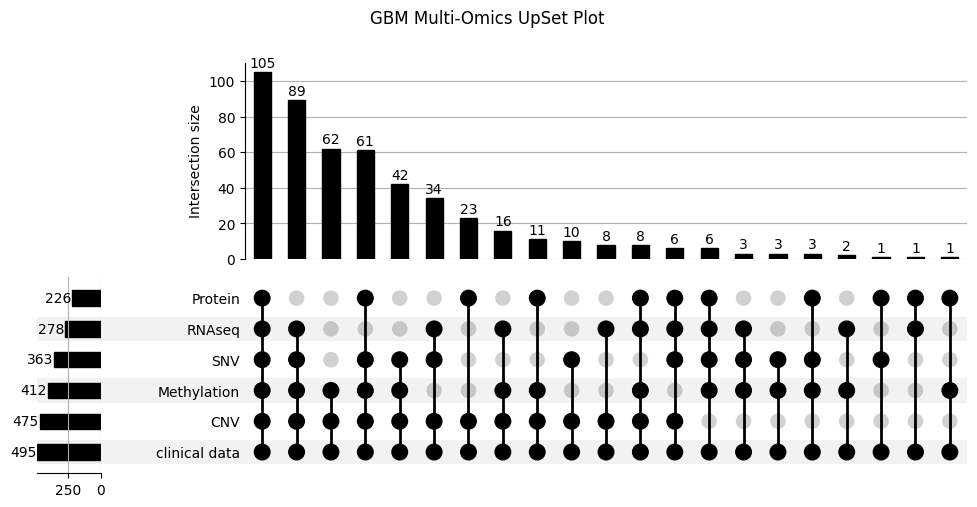

/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

<Figure size 1000x1000 with 0 Axes>

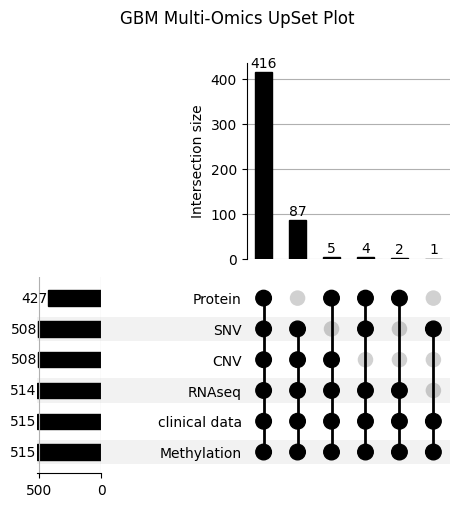

In [61]:
GBM_omics_combinations = assign_samples_by_omics_priority(GBM_omics_MOFA)
LGG_omics_combinations = assign_samples_by_omics_priority(LGG_omics_MOFA)
plot_upset_from_omics_combinations(GBM_omics_combinations, title="GBM Multi-Omics UpSet Plot")
plot_upset_from_omics_combinations(LGG_omics_combinations, title="GBM Multi-Omics UpSet Plot")

In [62]:
print("Total # of filtered GBM samples:", len(filtered_GBM_smaples))
print("Total # of filtered LGG samples:", len(filtered_LGG_samples))

Total # of filtered GBM samples: 495
Total # of filtered LGG samples: 515


In [63]:
print('# of GBM SNV samples:', len(GBM_SNV_MOFA_sample))
print('# of GBM protein samples:', len(GBM_protein_MOFA_sample))
print('# of GBM methylation samples:', len(GBM_methylation_MOFA_sample))
print('# of GBM CNV samples:', len(GBM_CNV_MOFA_sample))
print('# of GBM RNA_seq samples:', len(GBM_rna_seq_MOFA_sample))
print('')
print('# of LGG SNV samples:', len(LGG_SNV_MOFA_sample))
print('# of LGG protein samples:', len(LGG_protein_MOFA_sample))
print('# of LGG methylation samples:', len(LGG_methylation_MOFA_sample))
print('# of LGG CNV samples:', len(LGG_CNV_MOFA_sample))
print('# of LGG RNA_seq samples:', len(LGG_rna_seq_MOFA_sample))

# of GBM SNV samples: 363
# of GBM protein samples: 226
# of GBM methylation samples: 412
# of GBM CNV samples: 475
# of GBM RNA_seq samples: 278

# of LGG SNV samples: 508
# of LGG protein samples: 427
# of LGG methylation samples: 515
# of LGG CNV samples: 508
# of LGG RNA_seq samples: 514


In [ ]:
with open(Ds_project_folder_path + data_clearning_path +'GBM_omics_samples_MOFA.pickle', 'wb') as f:
    pickle.dump(GBM_omics_MOFA, f, pickle.HIGHEST_PROTOCOL)

with open(Ds_project_folder_path + data_clearning_path +'LGG_omics_samples_MOFA.pickle', 'wb') as f:
    pickle.dump(LGG_omics_MOFA, f, pickle.HIGHEST_PROTOCOL)